In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers



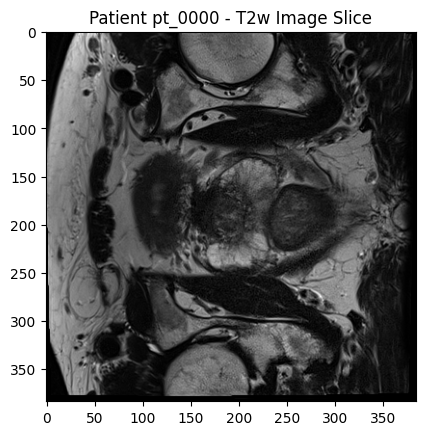

In [2]:
# Function to load NIfTI images for a patient
def load_nifti_images(patient_id, data_dir):
    t2w_file = os.path.join(data_dir, f'{patient_id}', 't2w.nii')
    adc_file = os.path.join(data_dir, f'{patient_id}', 'adc.nii')
    ktrans_file = os.path.join(data_dir, f'{patient_id}', 'ktrans.nii')

    t2w_img = nib.load(t2w_file).get_fdata()
    adc_img = nib.load(adc_file).get_fdata()
    ktrans_img = nib.load(ktrans_file).get_fdata()

    return t2w_img, adc_img, ktrans_img

patient_id = 'pt_0000'
data_dir = 'data/mri'
t2w_img, adc_img, ktrans_img = load_nifti_images(patient_id, data_dir)

plt.imshow(t2w_img[:, :, t2w_img.shape[2] // 2], cmap='gray')
plt.title(f'Patient {patient_id} - T2w Image Slice')
plt.show()


In [3]:
# Load labels from info.csv
csv_file = 'data/info.csv'
df = pd.read_csv(csv_file)

print(df.head())

df = df[['pt_id', 'ijk', 'label']]  


   index    pt_id Name  fid         ijk           Dim  label
0      1  pt_0000  t2w    1   167 224 9  384x384x19x1   True
1      2  pt_0001  t2w    1  157 186 10  384x384x19x1  False
2      3  pt_0002  t2w    2  203 216 10  384x384x19x1  False
3      4  pt_0002  t2w    1  154 217 12  384x384x19x1   True
4      5  pt_0003  t2w    1  240 205 12  384x384x21x1  False


In [4]:
def extract_finding_with_padding(ijk, img, target_size=32):
    i, j, k = [int(x) for x in ijk.split()]  
    
    half_size = target_size // 2

    # Extract sub-region around the finding
    extracted_img = img[max(i-half_size, 0):i+half_size, max(j-half_size, 0):j+half_size, max(k-half_size, 0):k+half_size]
    
    # Determine the actual shape of the extracted image
    actual_shape = extracted_img.shape

    # Padding each axis to reach the target size
    pad_x = target_size - actual_shape[0]
    pad_y = target_size - actual_shape[1]
    pad_z = target_size - actual_shape[2]
    
    # Apply padding
    padded_img = np.pad(extracted_img, 
                        ((0, pad_x), (0, pad_y), (0, pad_z)), 
                        mode='constant', constant_values=0)
    
    return padded_img

ijk = '50 60 40'  
finding_img = extract_finding_with_padding(ijk, t2w_img)

print(f'Shape of the padded finding: {finding_img.shape}')


Shape of the padded finding: (32, 32, 32)


In [5]:
print(len(finding_img))

32


In [6]:
findings_data = []
labels = []

for index, row in df.iterrows():
    patient_id = str(row['pt_id']).zfill(4)
    ijk = row['ijk']
    label = row['label']

    # Load MRI images
    t2w_img, adc_img, ktrans_img = load_nifti_images(patient_id, data_dir)
    
    t2w_finding = extract_finding_with_padding(ijk, t2w_img)
    adc_finding = extract_finding_with_padding(ijk, adc_img)
    ktrans_finding = extract_finding_with_padding(ijk, ktrans_img)

    # Stack the three images (T2w, ADC, Ktrans) into a 3D array
    finding_combined = np.stack([t2w_finding, adc_finding, ktrans_finding], axis=-1)
    
    findings_data.append(finding_combined)
    labels.append(label)

X = np.array(findings_data)
y = np.array(labels)

# Normalize the pixel values
X = X / np.max(X)

# Convert labels to binary
y = to_categorical(y)

# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')


Shape of X_train: (228, 32, 32, 32, 3)
Shape of y_train: (228, 2)


In [7]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

228
228
98
98


In [8]:
print(len(findings_data))  
print(len(findings_data[0]))  
print(len(findings_data[0][0]))  
print(len(findings_data[0][0][0]))


326
32
32
32


In [9]:
log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)



In [10]:
# CNN Model for 3D MRI Data
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(32, 32, 32, 3)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    # Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # 2 output neurons for two classes (CS-PCa or not)
])




model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



model.summary()


C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 30, 30, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 15, 15, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 108000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,912,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,914,818 (26.38 MB)

 Trainable params: 6,914,818 (26.38 MB)

 Non-trainable params: 0 (0.00 B)

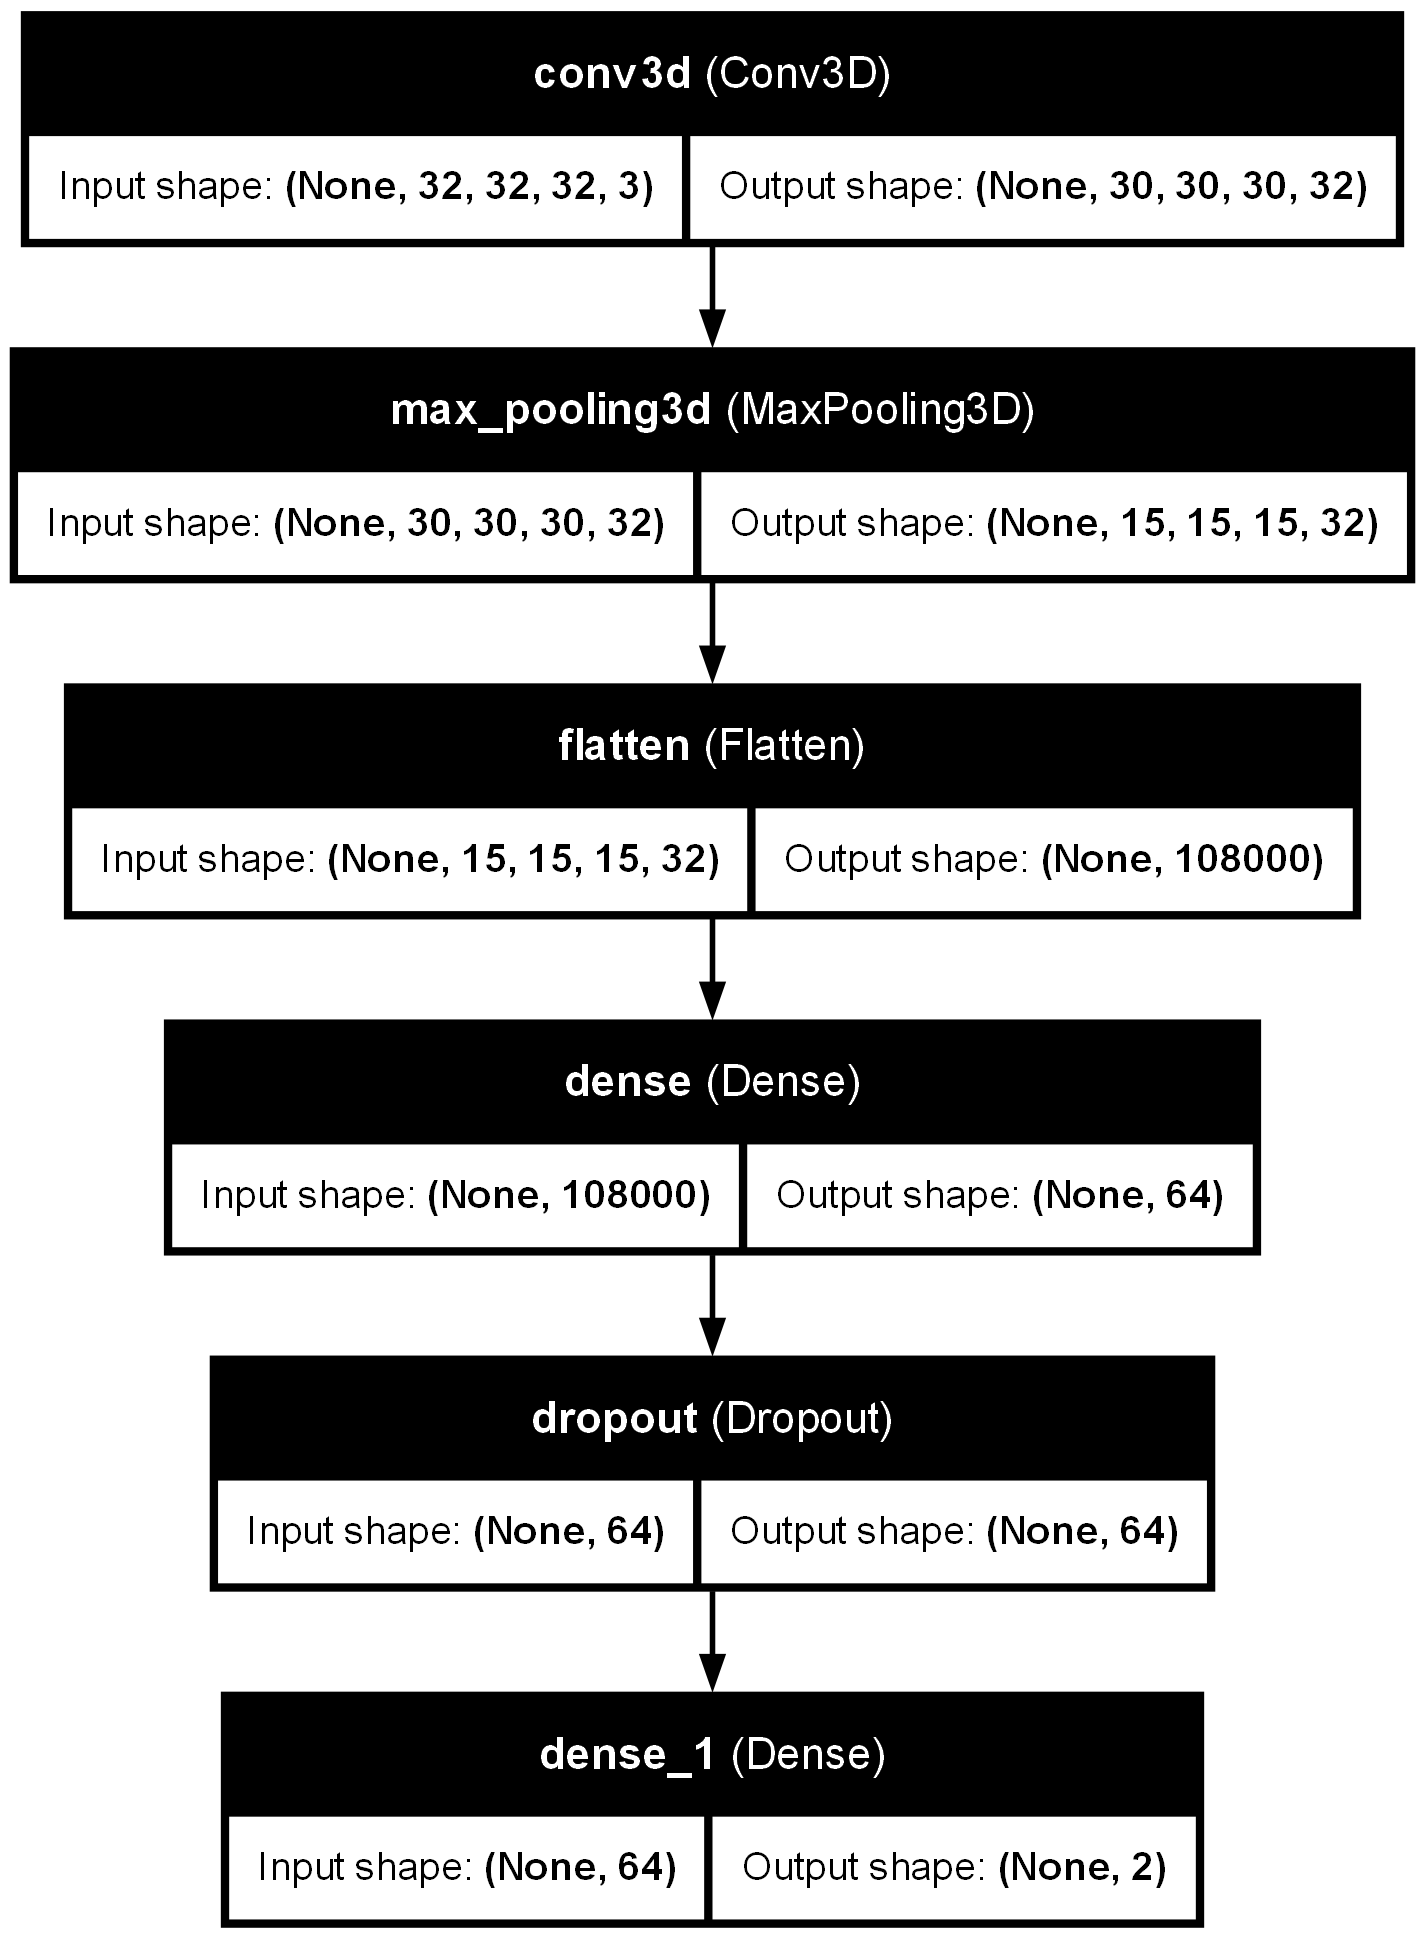

In [11]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=8, callbacks=[tensorboard_callback])



Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.6476 - loss: 1.1097 - val_accuracy: 0.7551 - val_loss: 0.5907
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.7664 - loss: 0.5637 - val_accuracy: 0.7551 - val_loss: 0.6024
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.8286 - loss: 0.4772 - val_accuracy: 0.7143 - val_loss: 0.6303
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.7760 - loss: 0.5429 - val_accuracy: 0.7551 - val_loss: 0.6322
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8003 - loss: 0.4940 - val_accuracy: 0.7449 - val_loss: 0.6220
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.7191 - loss: 0.5603 - val_accuracy: 0.7551 - val_loss: 0.8599
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.8004 - loss: 0.5291 - val_accuracy: 0.7449 - val_loss: 0.6537
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.8276 - loss: 0.3918 - val_acc

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6984 - loss: 3.3594
Test Accuracy: 0.6938775777816772


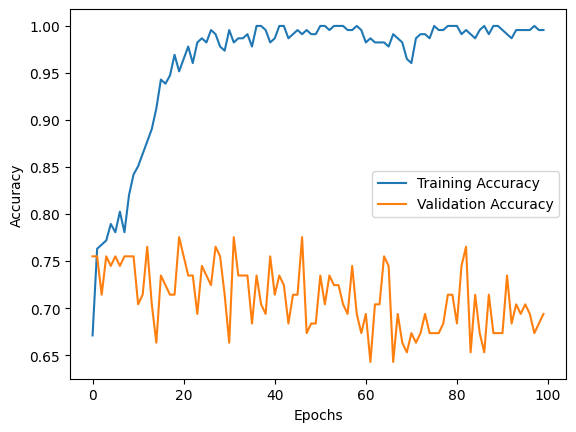

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
train_features = model.predict(X_train)  # Shape: (num_samples, 2)
val_features = model.predict(X_test) 

y_train_single = np.argmax(y_train, axis=1)
y_val_single = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=8)

# Train the Random Forest classifier on the CNN's features
rf_classifier.fit(train_features, y_train)

# Make predictions with the Random Forest classifier on validation features
y_val_pred_rf = rf_classifier.predict(val_features)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_val_pred_rf)
print(f"Random Forest Accuracy on Validation Data: {rf_accuracy * 100:.2f}%")


Random Forest Accuracy on Validation Data: 70.41%


In [16]:
from sklearn.svm import SVC
import numpy as np

# Convert one-hot encoded labels to single class labels
y_train_single = np.argmax(y_train, axis=1)
y_val_single = np.argmax(y_test, axis=1)


# Train SVM with single class labels
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(train_features, y_train_single)

# Predict and evaluate with single class labels
y_val_pred_svm = svm_classifier.predict(val_features)
svm_accuracy = accuracy_score(y_val_single, y_val_pred_svm)
print(f"SVM Accuracy on Validation Data: {svm_accuracy * 100:.2f}%")


SVM Accuracy on Validation Data: 70.41%


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression
logreg_classifier = LogisticRegression(random_state=42)
logreg_classifier.fit(train_features, y_train_single)

# Predict and evaluate
y_val_pred_logreg = logreg_classifier.predict(val_features)
logreg_accuracy = accuracy_score(y_val_single, y_val_pred_logreg)
print(f"Logistic Regression Accuracy on Validation Data: {logreg_accuracy * 100:.2f}%")


Logistic Regression Accuracy on Validation Data: 70.41%


In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, y_train_single)

# Predict and evaluate
y_val_pred_knn = knn_classifier.predict(val_features)
knn_accuracy = accuracy_score(y_val_single, y_val_pred_knn)
print(f"K-Nearest Neighbors Accuracy on Validation Data: {knn_accuracy * 100:.2f}%")


K-Nearest Neighbors Accuracy on Validation Data: 70.41%


In [19]:
from sklearn.ensemble import VotingClassifier

# Ensemble of classifiers
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svm', svm_classifier),
    ('logreg', logreg_classifier),
    ('knn', knn_classifier)
], voting='hard')

# Train the voting classifier
voting_classifier.fit(train_features, y_train_single)

# Predict and evaluate
y_val_pred_voting = voting_classifier.predict(val_features)
voting_accuracy = accuracy_score(y_val_single, y_val_pred_voting)
print(f"Ensemble Voting Classifier Accuracy: {voting_accuracy * 100:.2f}%")


Ensemble Voting Classifier Accuracy: 70.41%


In [30]:
from tensorflow.keras.optimizers import Adam
from keras_tuner import Hyperband

def build_model(hp):
    model = Sequential()
    
    # Convolutional Layers
    model.add(Conv3D(
        filters=hp.Choice('filters_1', values=[32, 64, 128], default=64),
        kernel_size=(3, 3, 3),
        activation='relu',
        input_shape=(32, 32, 32, 3),
        kernel_regularizer=regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-3))
    ))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv3D(
        filters=hp.Choice('filters_2', values=[32, 64, 128], default=64),
        kernel_size=(3, 3, 3),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-3))
    ))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())
    
    # model.add(Conv3D(
    #     filters=hp.Choice('filters_3', values=[32, 64, 128], default=64),
    #     kernel_size=(3, 3, 3),
    #     activation='relu'
    # ))
    # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # model.add(BatchNormalization())
    
    model.add(Flatten())
    
    # Dense Layers
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.3, 0.5, 0.7, 0.9])))
    
    # Output Layer
    model.add(Dense(2, activation='softmax'))
    
    # Compile the Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [31]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='prostate_cancer_detection'
)


In [32]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Trial 30 Complete [00h 02m 24s]
val_accuracy: 0.7551020383834839

Best val_accuracy So Far: 0.7755101919174194
Total elapsed time: 00h 38m 46s


In [33]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Model Validation Accuracy: {val_accuracy * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7821 - loss: 8.8943
Best Model Validation Accuracy: 77.55%


In [34]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Filters Layer 1: {best_hyperparameters.get('filters_1')}")
print(f"Filters Layer 2: {best_hyperparameters.get('filters_2')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Dropout Rate: {best_hyperparameters.get('dropout_rate')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")


Best Hyperparameters:
Filters Layer 1: 64
Filters Layer 2: 64
Dense Units: 64
Dropout Rate: 0.3
Learning Rate: 0.01


In [35]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_train, y_train)
print(f"Best Model Validation Accuracy: {val_accuracy * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7690 - loss: 1.0646
Best Model Validation Accuracy: 76.75%
